# Geometric Brownian Motion

GBM is a time-continuous stochastice process. *What does it mean?*<br>
Imagine a stock price vs time graph. How can we expect it's shape to be?<br>
2 things will affect stock price movement under this model :
1. $\mu \Rightarrow$ the drift
2. $\sigma \Rightarrow$ the volatility
3. ${W_t} \Rightarrow$ the Wiener process or Brownian Motion


We will simulate call option prices using monte carlo method and the **Black-Scholes formula**. And later we will look at the convergence of the call price from one method to another which is known as **boot-strapping**.

In [2]:
#import stuff

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

First we simulate stock prices using the GBM equation:

$$ {ds_t} = {S_t}(\mu{dt} + \sigma{W_t} )$$
${S_t}$ is the stock price at time t.<br>
${{ds}_t} = {S_t}-{S_{t-1}}$



In [3]:
def gbm1(so,mu,sigma,t,dt,n):
    
    path = []
    
    for i in range(n):
    
        price = [so] #initial stock price
        time=0
    
        while(time+dt<=t):
        
            new_price = price[-1]*np.exp( mu*dt + sigma*np.random.normal(0,dt) ) #gbm equation
            price.append(new_price)
            time+=dt
        
        if(t-time>0):
            new_price = price[-1]*np.exp( mu*dt + sigma*np.random.normal(0,dt) )
            #new_price = price[-1]*np.exp((mu-0.5*(sigma**2))*(t-time) + sigma*(np.random.normal(0,np.sqrt(t-time))))
            price.append(new_price)
        
        
        path.append(price)
    
    return path
    

In [42]:

so = 100 #intial stock price
mu = 0.08 #mean return rate
sigma = 0.3 #stock drift/volatility rat
t = 1 #1 year time period
dt = 1/252 #1 trading day, a year has ~252 trading days
n = 1000 #no. of simulations

sample_paths = gbm1(so,mu,sigma,t,dt,n)
print(len(sample_paths))
print(len(sample_paths[56]))
#print(sample_paths)

1000
254


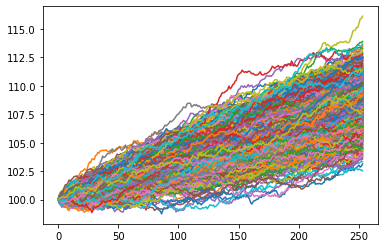

In [5]:
for path in sample_paths:
    plt.plot(path)

## Understanding the above stock price simulation

What we did was simulate stock prices,for 252 days, using the geometric brownian motion. And we did this 1000 times. Each of the 1000 *stock paths* contains 254 *stock prices* for that particular simulation.

The GM equation for stock prices, given by:

$$ {ds_t} = {S_t}(\mu{dt} + \sigma{W_t} )$$

or

$$ {y_{t_i}} = \frac{S_{t_i}-{S_{t_i}}}{S_{t_{i-1}}} = \mu{dt} + \sigma{W_t}$$

This is the stock price returns for the ${i^{th}}$ run of the simulation.

We get the final stock price of the ${i^{th}}$ run of the simulation by 

$$ {S_t} = {S_0}\exp{\sum_{i=1}^{n}{y_{t_i}}}$$

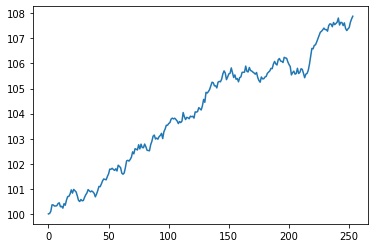

107.88316261568649

In [7]:
plt.plot(sample_paths[56])
plt.show()
sample_paths[56][-1]

In [10]:
log_returns = []

for i in range(1,len(sample_paths[56])):
    y = np.log(sample_paths[56][i]/sample_paths[56][i-1])
    log_returns.append(y)


st_56 = so*np.exp(sum(log_returns))
print(st_56) 


107.88316261568647


The above code snippet is to check the formula holds good for calculating stock prices. We will now write a function to calculate the final stock prices of all simulated paths below.

In [32]:
def cal_stock_prices():
    
    stock_prices = []
    
    for i in range(0,len(sample_paths)):
    
        returns = [] #stores log returns for the ith simualtion of stock prices
    
        for j in range(1,len(sample_paths[i])):
            y = np.log(sample_paths[i][j]/sample_paths[i][j-1])
            returns.append(y)
        
        y_i = np.exp(sum(returns))
        
        s_i = so * y_i #the ith stock price
    
        stock_prices.append(s_i)
    return stock_prices
   

In [36]:
a = cal_stock_prices() #all 1000 stocks prices are stored in a
print(a[100])
print(sample_paths[100][-1])
print(len(a))


105.43928651898298
105.43928651898302
1000


In [40]:
k = 105 # the strike price of the call option, expiring after 1 year

calls = []

def get_call(s):
        
        for i in s:
            
            c = (i-k) if i>k else 0
            calls.append(c)
            
        return calls
        

In [45]:
c = get_call(a) #every call price for all the 1000 stock prices generated

print(sum(c)/len(c)) #averaging all call prices

3.4943431798670366


3.5 is the price of the option through this simulation method. Next we will re calculate the call option price using Black Scholes formula with the same parameters.

In [46]:
def get_options(so,r,sigma,t,dt,n,k):
    
    stock_prices = []
    option_prices = []
    for i in range(n):
    
        price = [so]
        calls = []
        time=0
        
        while(time+dt<=t):
        
            new_price = price[-1]*np.exp((r-0.5*(sigma**2))*dt + sigma*(np.random.normal(0,np.sqrt(dt))))
            price.append(new_price)
            time+=dt   
            
            d1=(np.log(price[-1]/k) + (r+(sigma**2)/2))/sigma*np.sqrt(dt)
            d2=(np.log(price[-1]/k) + (r-(sigma**2)/2))/sigma*np.sqrt(dt)
            
            c = price[-1]*(norm.cdf(d1)) - k*(np.exp(-r*dt)*(norm.cdf(d2)))
            calls.append(c)
        
        stock_prices.append(price)
        option_prices.append(calls)
    return (stock_prices,option_prices)
    

In [47]:
so = 100
r = 0.08
sigma = 0.3
t = 1
dt = 1/252
n = 1000
k = 105
stocks, calls = get_options(so,r,sigma,t,dt,n,k)


In [48]:
print(len(stocks),len(calls))

1000 1000


In [49]:
print(len(stocks[78]),len(calls[2]))

253 252


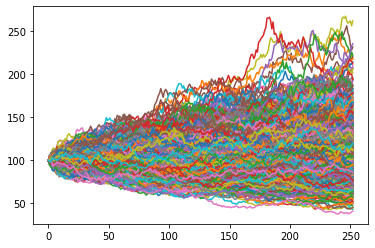

In [50]:
for i in stocks:
    plt.plot(i)

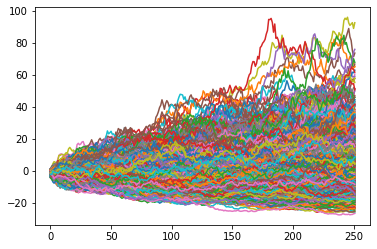

In [51]:
for i in calls:
    plt.plot(i)

In [52]:
new_calls = calls

for i in range(0,len(new_calls)):
    
    for j in new_calls[i]:
        
        new_calls[i] = [0 if j<0 else j for j in new_calls[i]]
        
    

In [132]:
c=0

for i in new_calls[45]:
    if i<0:
        c+=1
print(c)

0


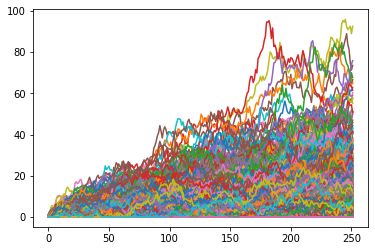

In [53]:
for i in new_calls:
    plt.plot(i)

In [54]:
#average call prices

avg_cp = []

for i in new_calls:
    
    avg_cp.append(sum(i)/len(i))
    
print(sum(avg_cp)/len(avg_cp))

4.50751534091647
